OCR with tesseract

In [57]:
import cv2
import pytesseract
import os
import PIL
from matplotlib import pyplot as plt
import numpy as np

#link the tesseract installation to pytesseract.
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


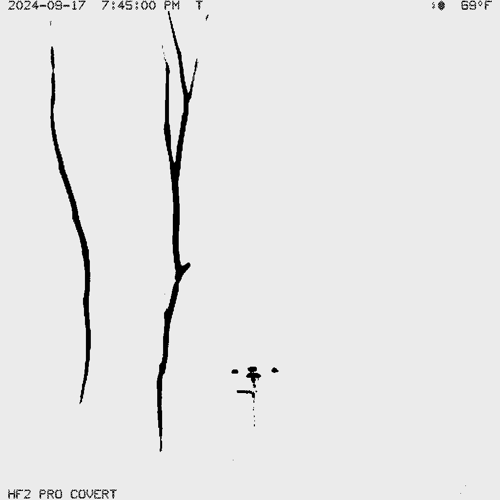

In [79]:
#get photo file paths
live_photo_location = '../photos/live_view/'
photo_files = os.listdir(live_photo_location)

#load a sample image
sample_img = cv2.imread(os.path.join(live_photo_location, photo_files[1]))

#convert to grayscale
sample_gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)

#apply thresholding to make text stand out
_, thresh = cv2.threshold(sample_gray, 220, 235, cv2.THRESH_BINARY_INV)

#view the images
PIL.Image.fromarray(thresh).resize((500,500))

In [59]:
text = pytesseract.image_to_string(thresh)

print(text)

eOLaM OGM EL Sea sOO FMF 3S Solr

'

HF? PRO COVERT



In [60]:
print(pytesseract.image_to_string(sample_img[:16,-100:]))

In [61]:
sample_img.shape

(720, 1024, 3)

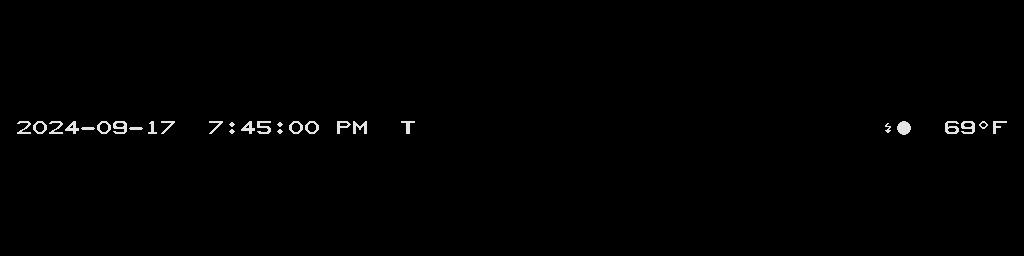

In [98]:
PILSample_img =  PIL.Image.fromarray(sample_img)

upper_pad = np.zeros((120,1024,3))
lower_pad = upper_pad.copy()

concatenated_image = np.concatenate([upper_pad, sample_img[:16], lower_pad])

PIL.Image.fromarray(concatenated_image.astype(np.uint8))

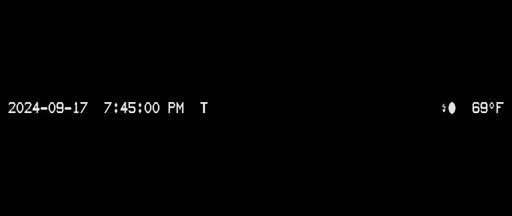

In [105]:
PIL.Image.fromarray(concatenated_image.astype(np.uint8)).resize((1024//2,216))

In [113]:
#just temperature
PIL.Image.fromarray(
    sample_img.astype(np.uint8)[0:16,924:1024]
)


In [75]:
print(pytesseract.image_to_string(concatenated_image.astype(np.uint8)))

2024-09-17 7:45:00 PM T *@ 69°F



# Do for all images

For each image, grab the image data, process to center/stretch text, isolate sections of date, time, T mode, save icon, and temperature. Pytesseract these sections and save in a dataframe.

In [1]:
import cv2
import pytesseract
import os
import PIL
from matplotlib import pyplot as plt
import numpy as np
import tqdm

#link the tesseract installation to pytesseract.
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


#get photo file paths
live_photo_location = '../photos/live_view/'
photo_files = [
                filename
                for filename in os.listdir(live_photo_location)
                if filename.endswith('.jpg')
]


#define regions of the image to isolate from the original.
#these are used to crop
#
crop_corners = {
    "whole":((0,720),(0,1024),(0,3)),
    "top bar":((0,16),(0,1024),(0,3)),
    "bottom bar":(),
    "date":(),
    "time":(),
    "t or not":(),
    "temperature":((0,16),(924,1024),(0,3)),
}
    
pad_size = 50

#prepare a list to fill with temperatures from the beginning
temp_text_list = []

for photo_filename in tqdm.tqdm(photo_files):

    #get image path
    photo_file_path = os.path.join(
                                    live_photo_location,
                                    photo_filename
    )
    
    #load the image as a numpy array
    this_img = cv2.imread(photo_file_path)

    #crop the array to temperate
    (x0,x1), (y0,y1), _ = crop_corners['temperature']
    this_img_temp = this_img[x0:x1,y0:y1,:]
    
    # cv2.imshow('Bloo', this_img_temp)


    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    #pad the image
    padded_this_img_temp = np.pad(this_img_temp,((pad_size,pad_size),(pad_size,pad_size),(0,0)))

    #get text from tesseract
    text = pytesseract.image_to_string(padded_this_img_temp)

    #chop off everything after the two digits at the beginning.
    text = text[:2]

    #add the text to the list
    temp_text_list.append(text)
    
    #view this image
    # cv2.imshow(text, padded_this_img_temp)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

100%|██████████████████████████████████████████████████████████████████████████████| 1227/1227 [02:31<00:00,  8.11it/s]


In [3]:
#save this data as a dataframe
import pandas as pd

save_file_path = '../weather-data/tesseract/tesseract_live_view.csv'
textdf = pd.DataFrame(temp_text_list, columns = ['temp'])

textdf.to_csv(save_file_path, index=None)

#look at what was found
temps = textdf.value_counts()
temps

temp
59      210
62      182
GO      167
SS      164
57      160
64       87
53       60
66       51
51       33
ZL       29
50       27
69       26
68       18
49        7
73        6
Name: count, dtype: int64

In [4]:
#SS is 55.
#GO is 60.
#ZL is 71.

replace_like_so = {'SS':'55', 'GO':'60', 'ZL':'71'}
textdf.replace(replace_like_so, inplace = True)

textdf['temp'] = textdf['temp'].astype(int)

tempvcs = textdf['temp'].value_counts()

In [5]:
tempvcs

temp
59    210
62    182
60    167
55    164
57    160
64     87
53     60
66     51
51     33
71     29
50     27
69     26
68     18
49      7
73      6
Name: count, dtype: int64

In [6]:
textdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   temp    1227 non-null   int32
dtypes: int32(1)
memory usage: 4.9 KB


<Axes: >

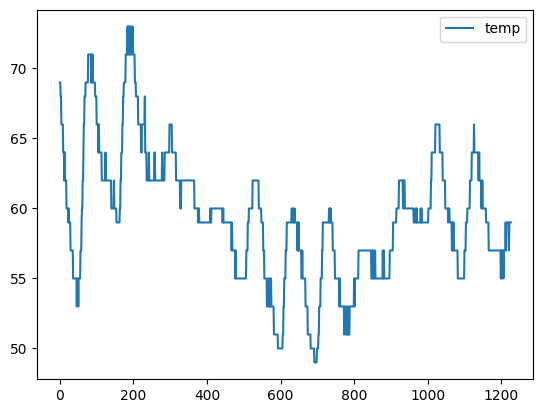

In [7]:
textdf.plot(y= 'temp')

In [12]:
#save this int-ed temperature data 
clean_temp_filepath = '../weather-data/tesseract/live_view_inted.csv'
textdf.to_csv(clean_temp_filepath, index = None)